In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [45]:
from pathlib import Path
from warnings import simplefilter
simplefilter("ignore")

In [40]:
import piplite
await piplite.install('seaborn') 
import seaborn as sns

In [72]:
oil= pd.read_csv('oil.csv',parse_dates =["date"])
stores= pd.read_csv('stores.csv')
holidays = pd.read_csv('holidays_events.csv',parse_dates =["date"])
transactions = pd.read_csv('transactions_sample.csv',parse_dates =["date"])
train = pd.read_csv('train_sample.csv',parse_dates =["date"])

In [9]:
oil  = oil.set_index("date").to_period()
oil.head(3)

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97


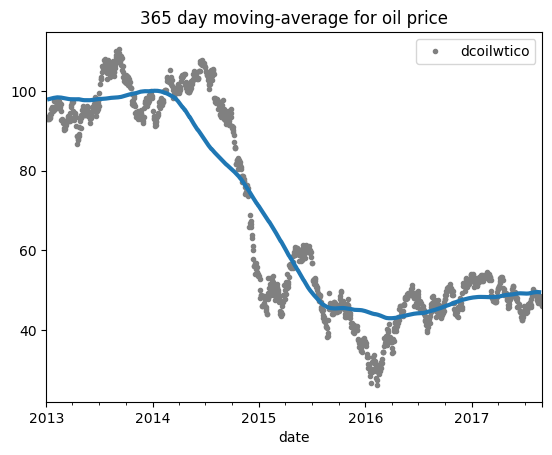

In [15]:
moving_average = oil.rolling(window=365, center=True, min_periods =183,).mean()
ax = oil.plot(style=".",color="0.5")
moving_average.plot(ax=ax, linewidth=3, title="365 day moving-average for oil price", legend=False);

In [16]:
from statsmodels.tsa.deterministic import DeterministicProcess

In [25]:
oil.dropna(inplace=True)

In [26]:
dp = DeterministicProcess( index = oil.index, constant = True, order =1, drop = True)
X = dp.in_sample()
X.tail()

,const,trend
date,,
2017-08-25,1.0,1171.0
2017-08-28,1.0,1172.0
2017-08-29,1.0,1173.0
2017-08-30,1.0,1174.0
2017-08-31,1.0,1175.0


In [20]:
from sklearn.linear_model import LinearRegression

In [27]:
y = oil["dcoilwtico"]

In [28]:
model = LinearRegression(fit_intercept=False)
model.fit(X,y)

LinearRegression(fit_intercept=False)

In [29]:
y_pred = pd.Series(model.predict(X), index=X.index)

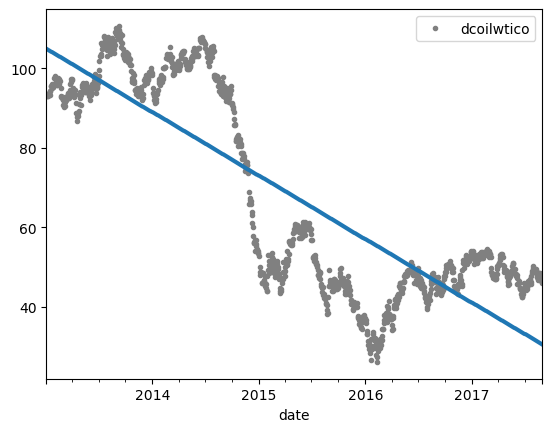

In [31]:
ax = oil.plot(style=".",color="0.5")
y_pred.plot(ax=ax, linewidth=3, label="Trend");

In [37]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

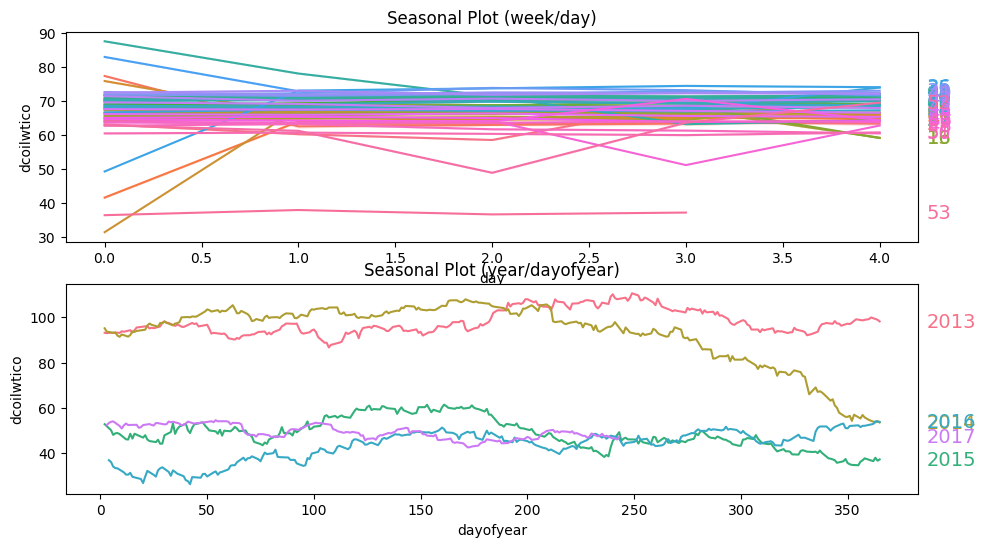

In [46]:
X = oil.copy()

X["day"] = X.index.dayofweek
X["week"] = X.index.week
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

fig, (ax0,ax1) =plt.subplots(2,1,figsize=(11,6))
seasonal_plot(X,y = "dcoilwtico", period ="week", freq="day",ax=ax0)
seasonal_plot(X,y = "dcoilwtico", period ="year", freq="dayofyear",ax=ax1);

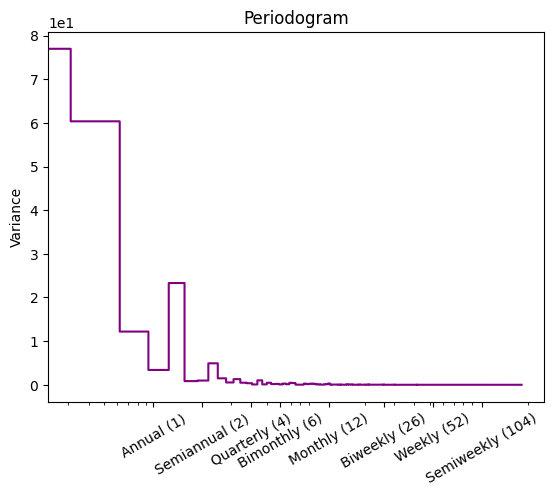

In [47]:
plot_periodogram(oil.dcoilwtico);

In [59]:
transactions.head(3)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358


In [77]:
train.head(3)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0


In [85]:
train_s = train.groupby(['date','store_nbr']).sum().sales

In [116]:
transactions_merged = pd.merge(transactions,train_s,on=['date','store_nbr'],how='outer')
transactions_merged.head(3)

,date,store_nbr,transactions,sales
0,2013-01-01,25,770.0,2511.618999
1,2013-01-02,1,2111.0,7417.148000
2,2013-01-02,2,2358.0,10266.718981


''

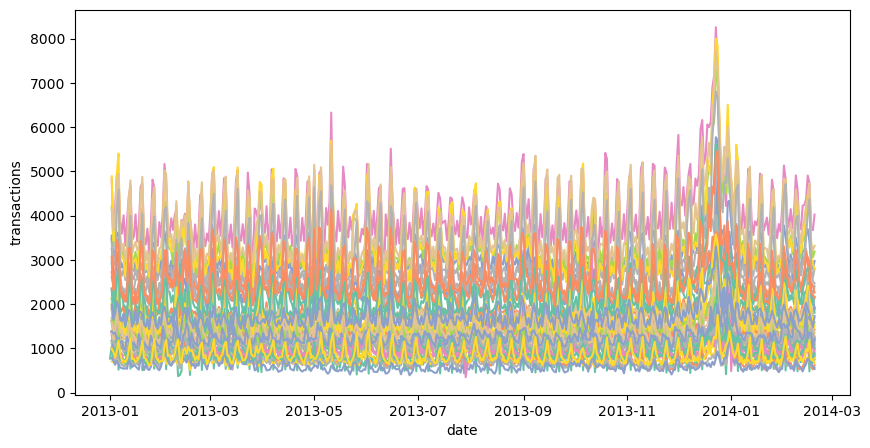

In [109]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x="date",y="transactions",hue="store_nbr",palette = "Set2",legend =False,data=transactions_merged)
;

In [110]:
# fig, ax = plt.subplots(figsize=(10,5))
# sns.lineplot(x="date",y="sales",hue="store_nbr",palette = "husl",legend =False,data=transactions_merged);

In [125]:
temp =transactions_merged.groupby('date').sum().drop("store_nbr",axis=1)
temp

,transactions,sales
date,,
2013-01-01,770.0,2511.618999
2013-01-02,93215.0,496092.417944
2013-01-03,78504.0,361461.231124
2013-01-04,78494.0,354459.677093
2013-01-05,93573.0,477350.121229
...,...,...
2014-02-15,93175.0,0.000000
2014-02-16,88232.0,0.000000
2014-02-17,76721.0,0.000000


In [127]:
from sklearn.model_selection import train_test_split

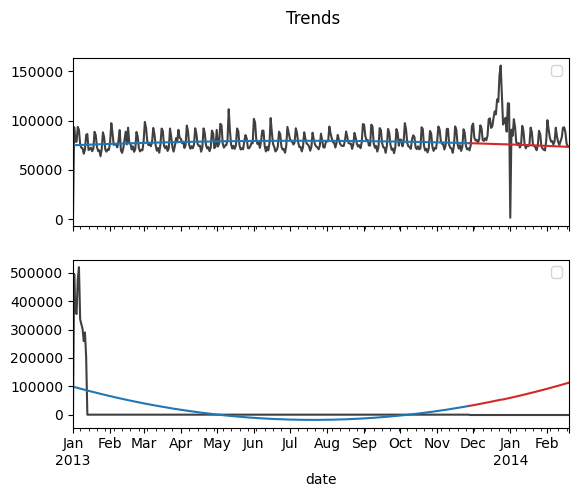

In [128]:
y = temp.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

# Test on the years 2016-2019. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=0.2, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")